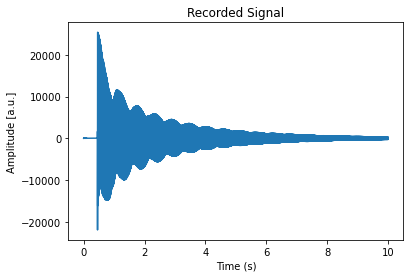

In [22]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import peakutils
from peakutils.plot import plot as pplot
from scipy.optimize import curve_fit
from numpy import pi,sqrt,arctan,tan

#%matplotlib tk
Tk().withdraw()
filename = askopenfilename() #open file dialog

# read audio samples
input_data = read(filename)
signal = input_data[1]
sampling_freq = input_data[0]
time = np.arange(len(signal))/sampling_freq

def plot_data(start_time,end_time):
	#function to plot data between start_time and end_time

	time_index1 = time.tolist().index(start_time)
	time_index2 = time.tolist().index(end_time)
	plt.figure()
	plt.plot(time[time_index1:time_index2+1],signal[time_index1:time_index2+1])
	plt.ylabel("Amplitude [a.u.]")
	plt.xlabel("Time (s)")
	plt.title("Recorded Signal")
	plt.show()

def FT_data(data,sampling_rate):
 #function to calculate and display absolute value of Fourier Transform

	freq = 0.5 * sampling_rate * np.linspace(-1.0, 1.0, len(data))
	FTdata = np.fft.fftshift(np.fft.fft(np.fft.fftshift(data)))

	freq_index1 = np.amin(np.where(freq >= 0))
	freq_index2 = np.amin(np.where(freq >= 3000))
	# plt.figure()
	# plt.plot(freq[freq_index1:freq_index2+1],abs(FTdata[freq_index1:freq_index2+1]))
	# plt.ylabel("Magnitude [a.u.]")
	# plt.xlabel("Frequency (Hz)")
	# plt.title("Absolute Value of Fourier Transform")
	# plt.show()
    
	return freq[freq_index1:freq_index2+1],abs(FTdata[freq_index1:freq_index2+1])



plot_data(0,10) #plot signal in time window defined by 2 values
freq, magn = FT_data(signal,sampling_freq) #Fourier Transform and plot absolute value
FFT_df = pd.DataFrame(np.vstack((freq, magn)).T, columns=['Frequency', 'Magnitude [a.u.]'])

In [74]:
def resonance_func(w,w0,N,v,b):
	resonance_curve = N/(sqrt(((w)**2-w0**2)**2+(v*(w))**2))+b
	return resonance_curve

def find_resn(signal,sampling_freq):
	#filename = askopenfilename() 
	FT_freq, magn = FT_data(signal,sampling_freq)

	indexes = peakutils.indexes(magn, thres=0.001, min_dist=2000)
	peaks = np.vstack((freq[indexes],magn[indexes])).T 
	
	freq_peaks_int = peakutils.interpolate(FT_freq, magn, ind=indexes) #interpolated

	
	plt.figure(figsize=(10,6))
	pplot(freq, magn, indexes)
	plt.title('First estimate')
	plt.show()
	#print(peaks)
	#print(freq_peaks_int)
	
	return [peaks, freq_peaks_int]
	
	'''
	resn_magn = []
	for m in magn:
			if m > 
	initial_guess=[143,5e9,1,100000] 
	po,po_cov=curve_fit(resonance_func,FT_freq,magn,initial_guess)
	plt.figure()
	plt.plot(FT_freq,magn)
	plt.plot(FT_freq,resonance_func(FT_freq,po[0],po[1],po[2],po[3]))
	print('f0 = %.3e +/- %.3e Hz' %(po[0],sqrt(po_cov[0,0])))
	print('N =  %.3e +/- %.3e' %(po[1],sqrt(po_cov[1,1])))
	print('v = %.3e +/- %.3e' %(po[2],sqrt(po_cov[2,2])))
	print('b = %.3e +/- %.3e' %(po[3],sqrt(po_cov[3,3])))
	'''

In [12]:
def tophat(start, end, end_of_graph, density):
    ini_plot_x = np.linspace(0, end_of_graph, density)
    y = [0] * len(ini_plot_x)
    for idx, x in enumerate(ini_plot_x):
        if x >= start and x <= end:
          y[idx] = 1

    return ini_plot_x, y

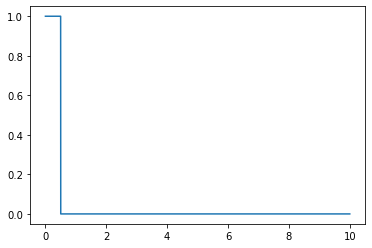

In [13]:
top_x, top_y = tophat(0,0.5,10,len(signal))
plt.plot(top_x,top_y)

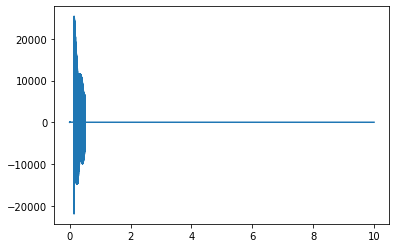

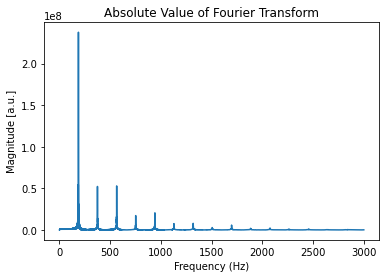

(array([0.00000000e+00, 3.16592915e-02, 6.33185829e-02, ...,
        2.99993948e+03, 2.99997114e+03, 3.00000280e+03]),
 array([ 43753.        ,  47448.07377243,  56969.99869794, ...,
        108108.94470413, 106721.97105797, 105918.98602511]))

In [14]:
func_prod = top_y * signal
plt.plot(top_x,func_prod)
FT_data(func_prod,sampling_freq)

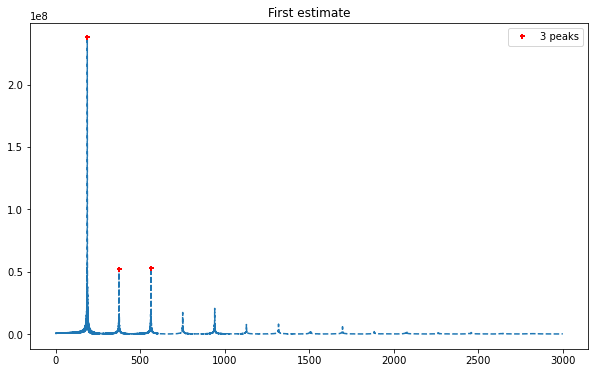

237784960.86246228
52266974.750634335
52904598.10614312


In [44]:
resn, freq_resi = find_resn(func_prod,sampling_freq)
for i in resn:
  print(i[1])

In [20]:
print(freq_resi)

[ 187.51396025  375.0050907   564.37251074  751.87268472  941.16461187
 1128.64843911 1318.63126315 1506.15164956 1697.06301487]


# finding the decay function

[237784960.86246228, 170445757.794914, 88807904.06552605, 48906183.356942214, 27587406.4427602, 15728781.167088956, 9004188.843219483, 5172758.492820284, 2973080.002636129, 1740980.331085232, 1064745.439328385, 604870.123717451, 352817.3136901137, 210277.5513317755, 82474.49371748566, 43754.92636655041, 39356.73966619167, 19256.794305475916, 51557.18519130797, 33683.14748318023]


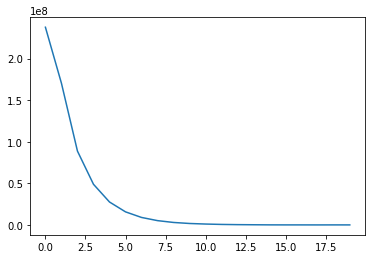

In [72]:
from xml.sax.handler import feature_string_interning


input_data_decay = read(filename)

def find_decay(input_data, left_range = 150, right_range = 225, time_interval = 0.5):
  signal = input_data[1]
  sampling_freq = input_data[0]
  amp_list = []
  freq_list = []

  for i in np.arange(0, 10, time_interval):
    top_x, top_y = tophat(i, i + time_interval, 10, len(signal))
    func_prod = top_y * signal
    resn, freq_resi = find_resn(func_prod,sampling_freq)
    
    for x in resn:
      if x[0] < right_range and x[0] > left_range:
        amp_list.append(x[1])
        freq_list.append(x[0])


  # plot_decay(amp_list, time_interval)
  plt.plot(amp_list)
  return amp_list, freq_list

def plot_decay(amplitude, time_interval):
  time = []
  for i in np.arange(0, 10, time_interval):
    time.append(i)
  plt.plot(time, amplitude)

#amp_list, freq_list = find_decay(input_data_decay)

#print(amp_list)



    


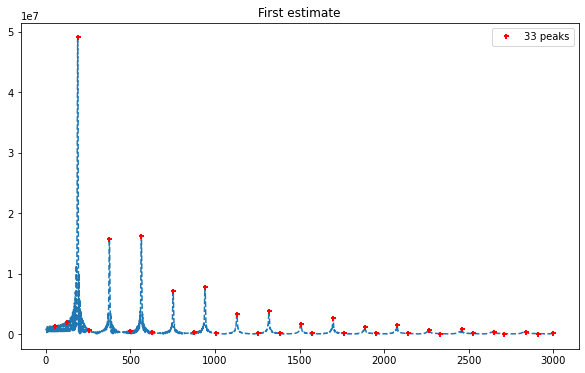

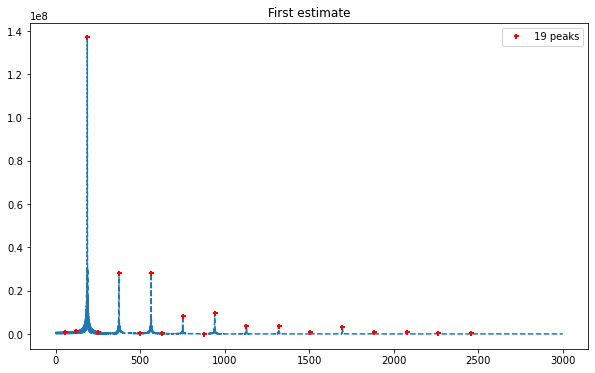

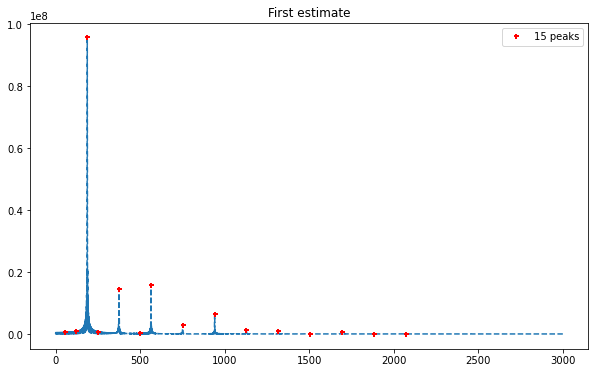

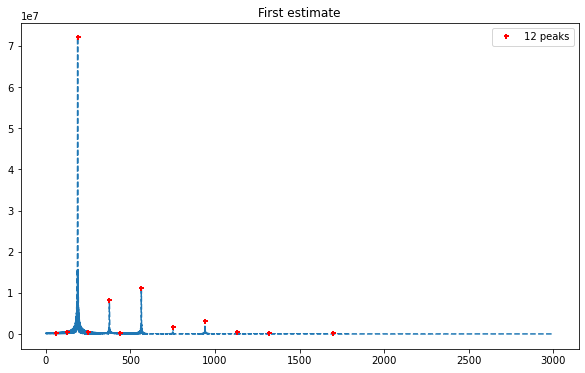

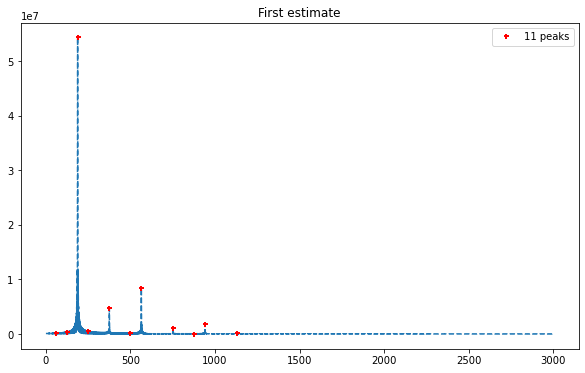

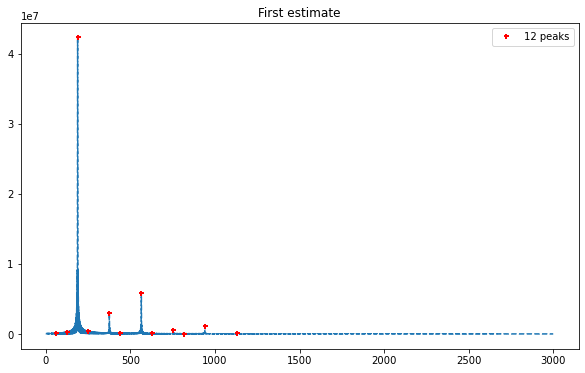

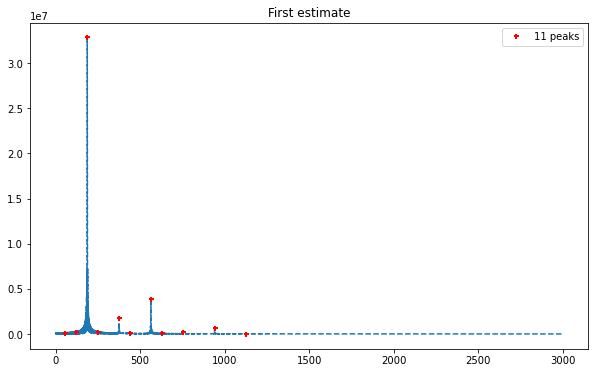

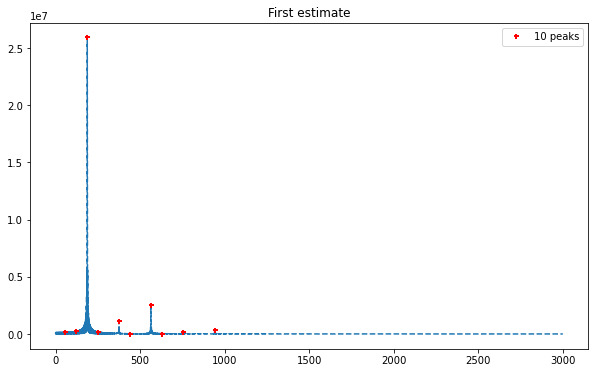

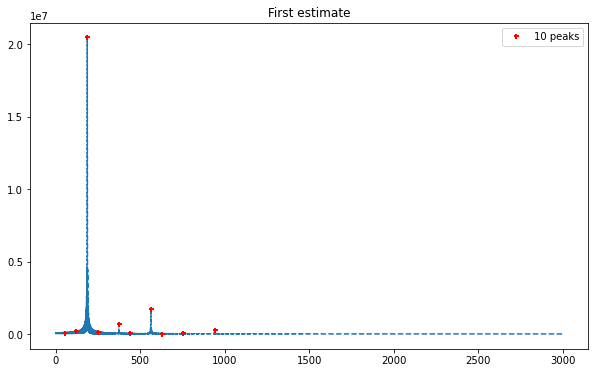

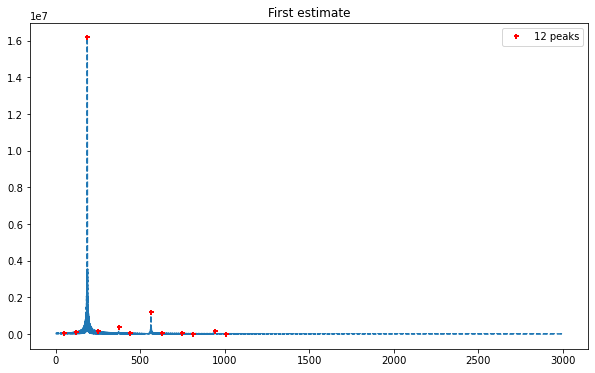

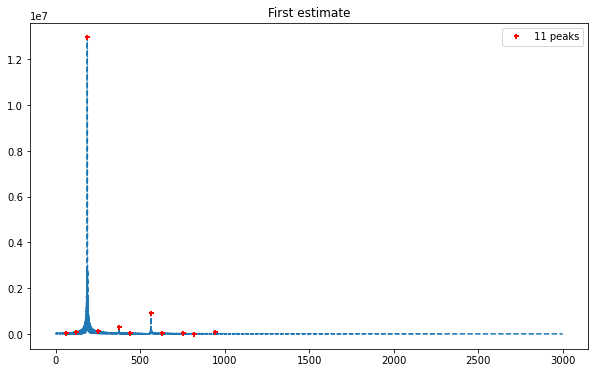

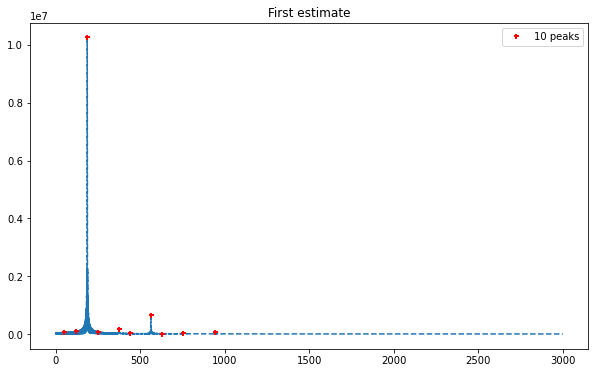

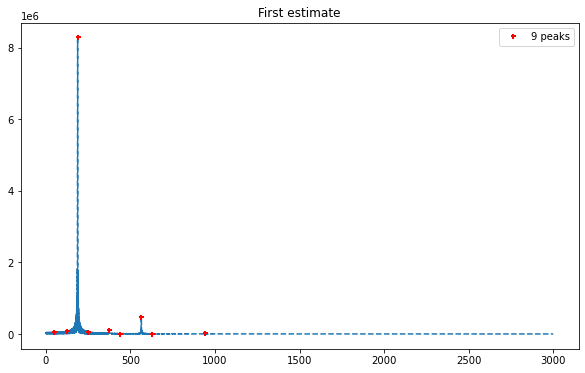

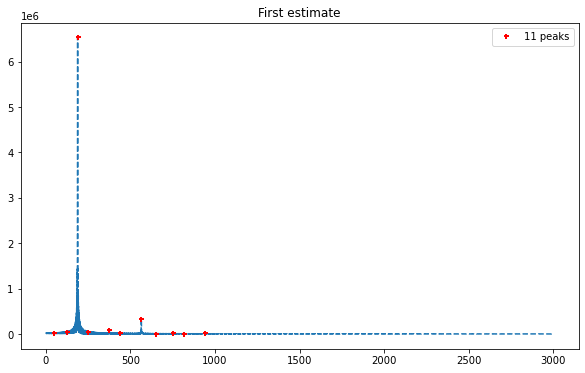

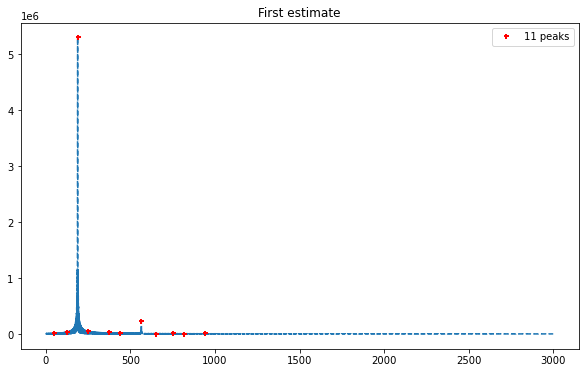

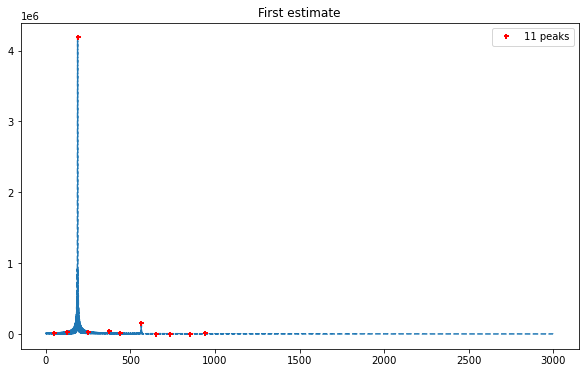

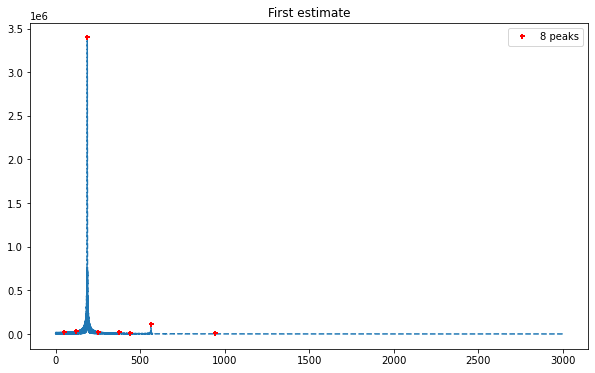

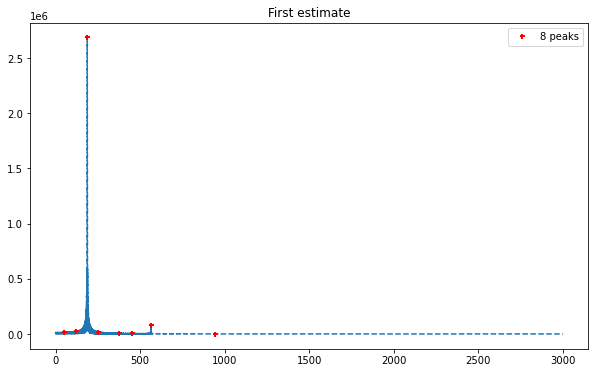

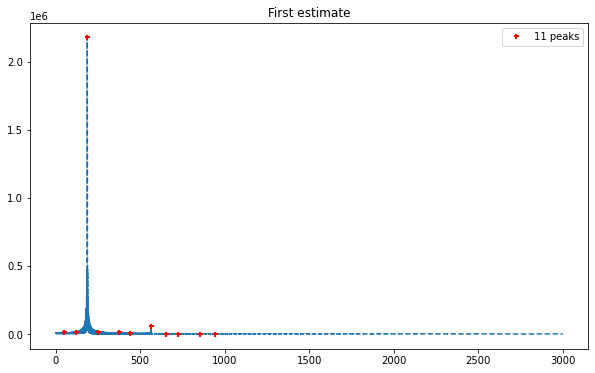

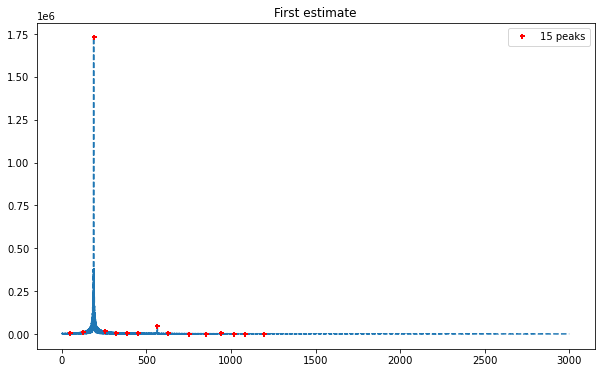

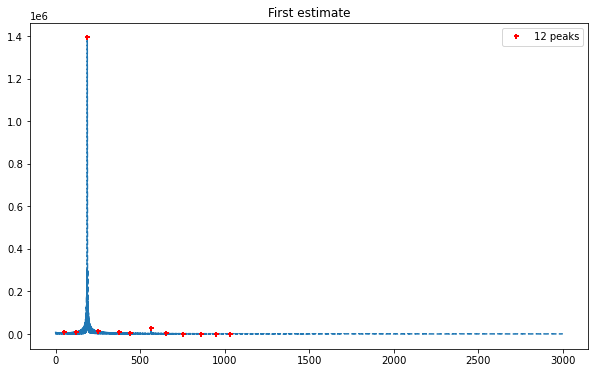

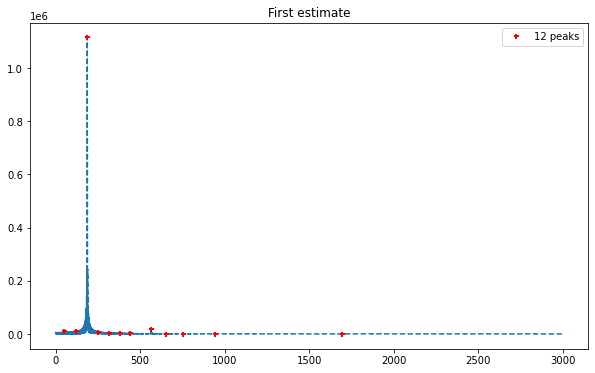

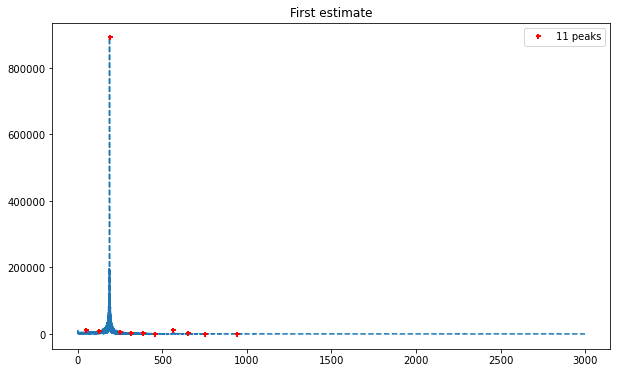

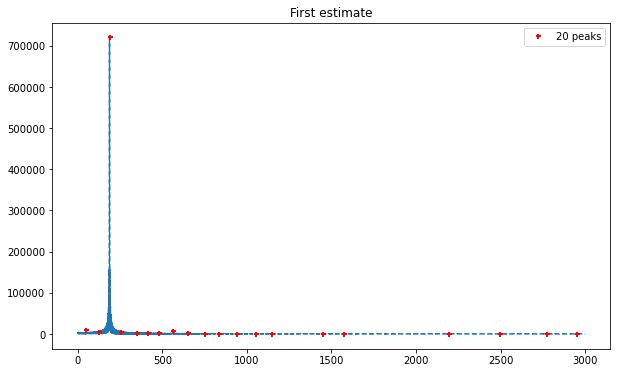

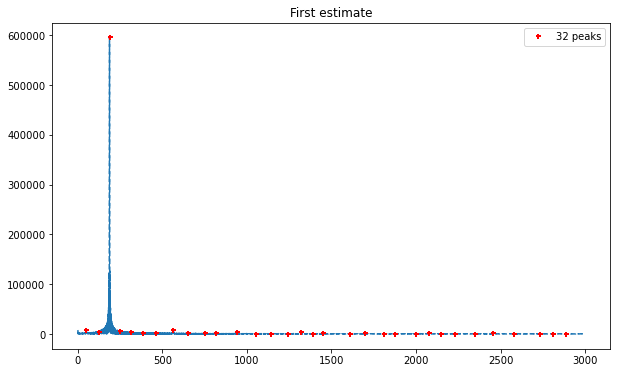

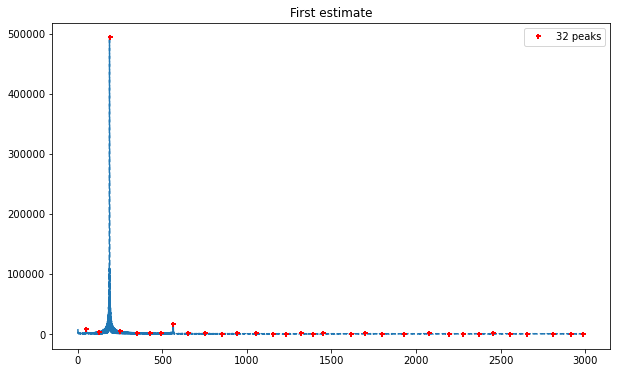

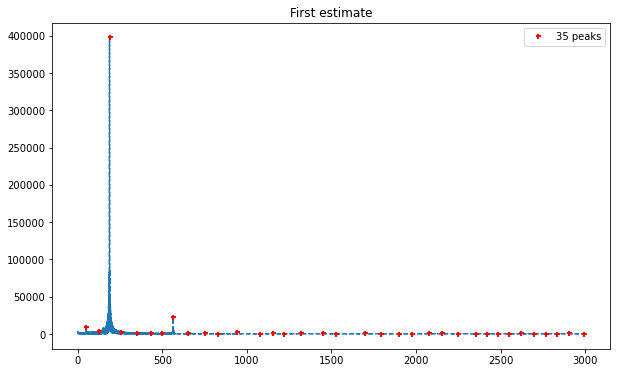

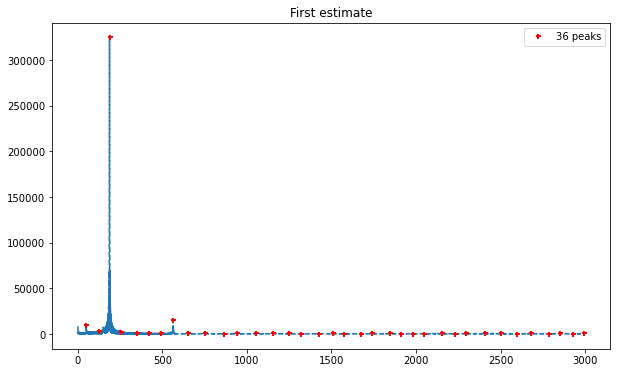

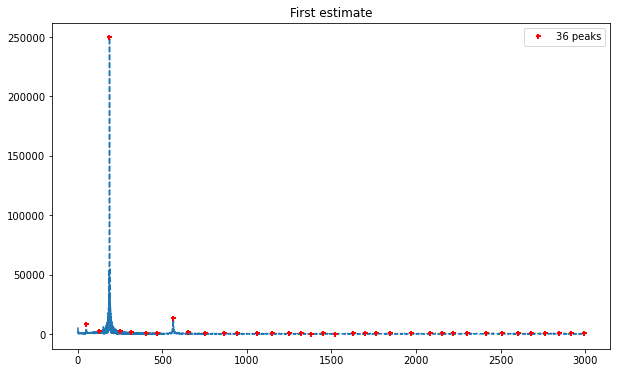

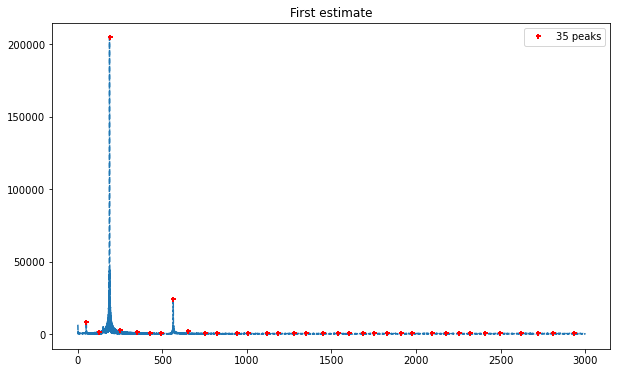

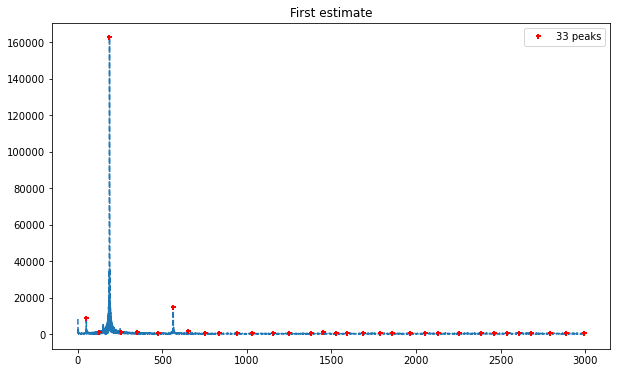

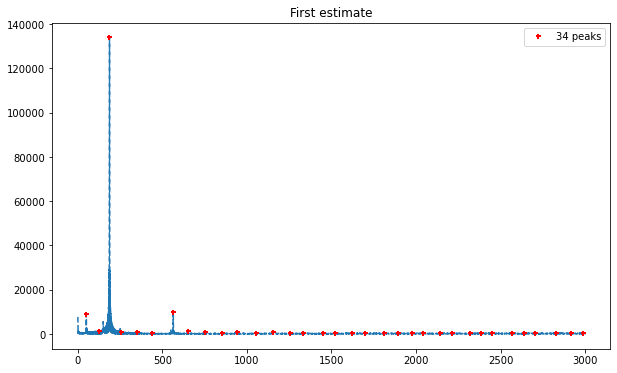

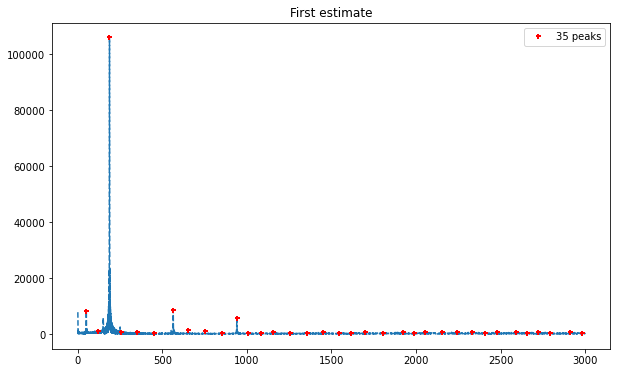

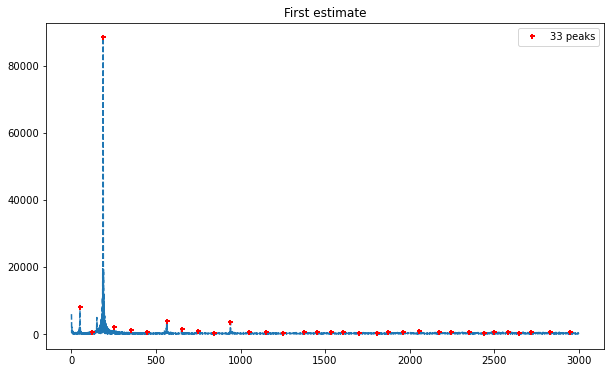

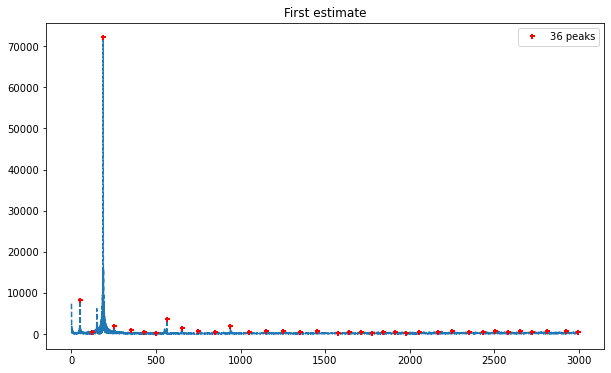

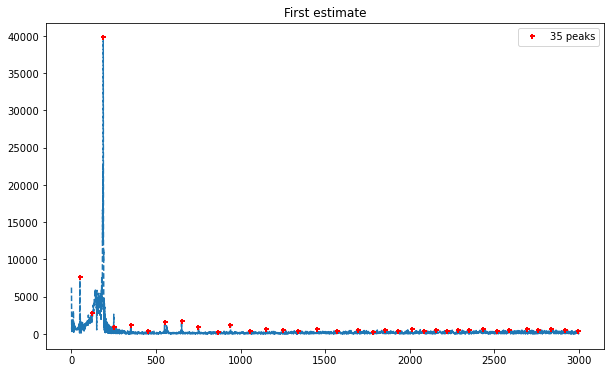

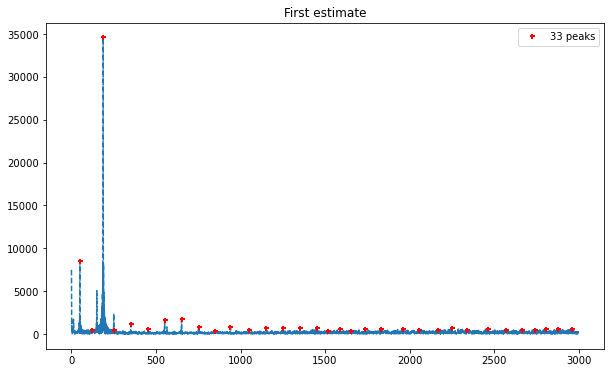

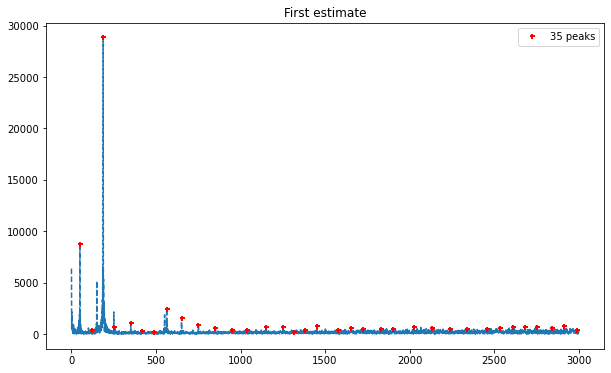

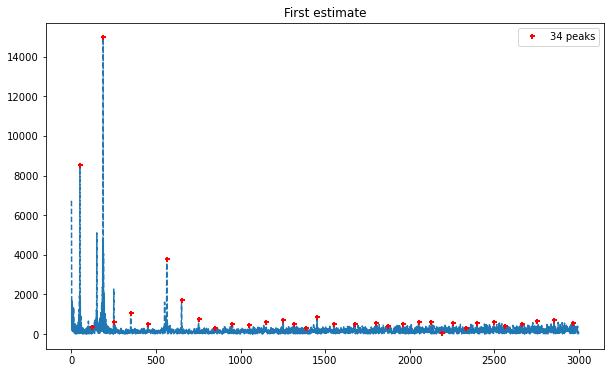

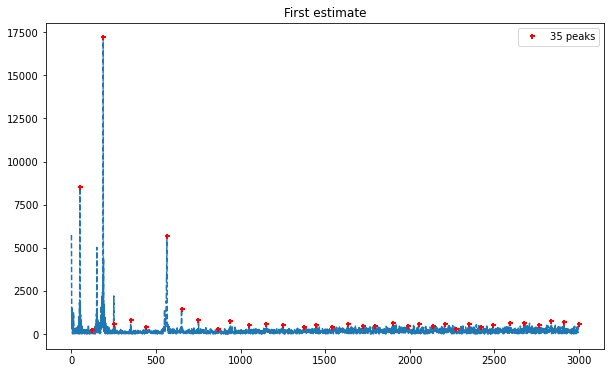

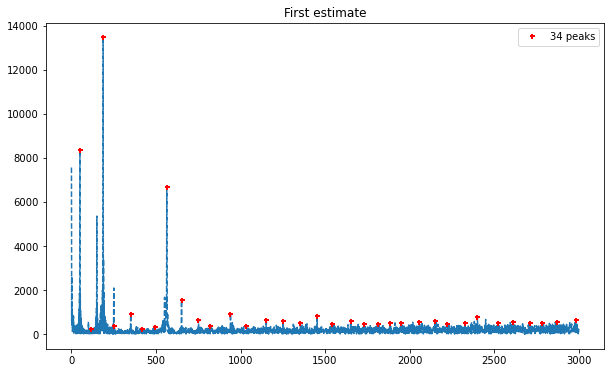

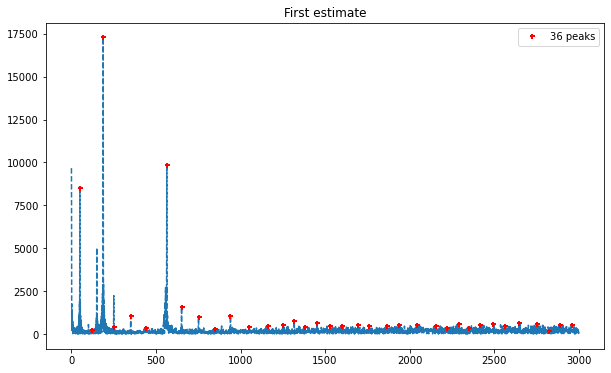

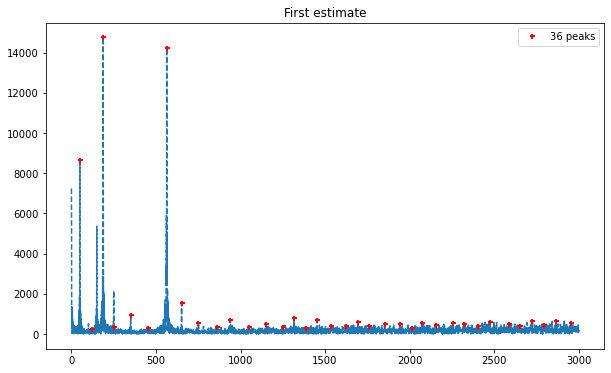

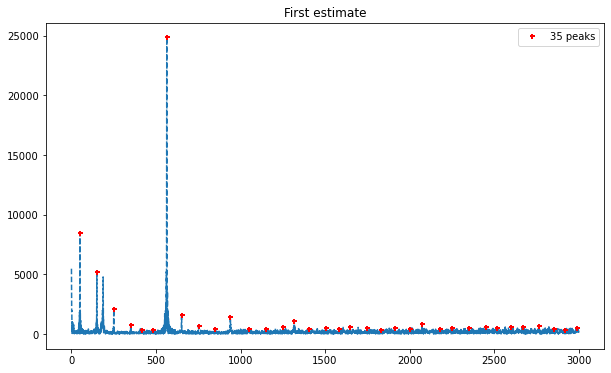

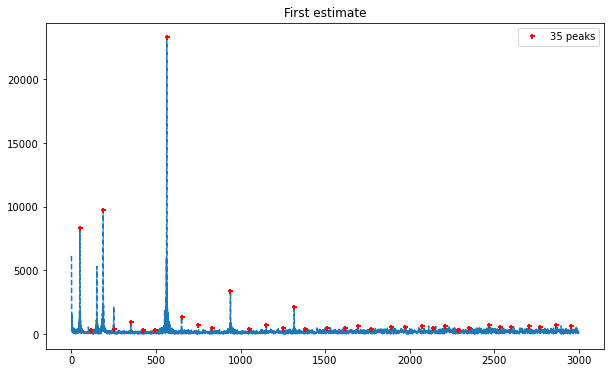

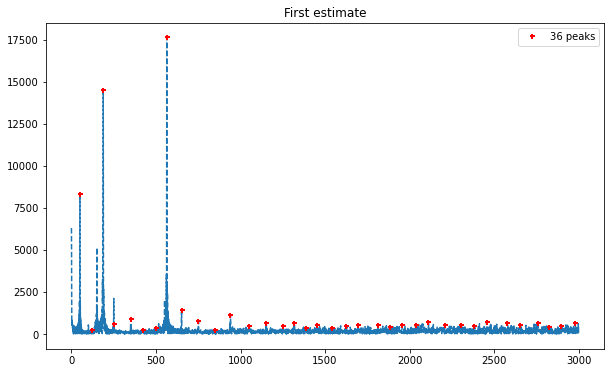

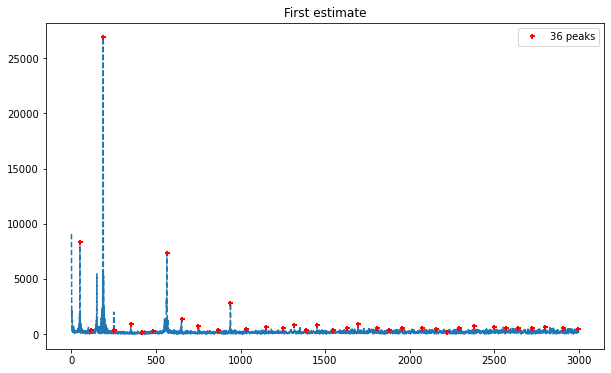

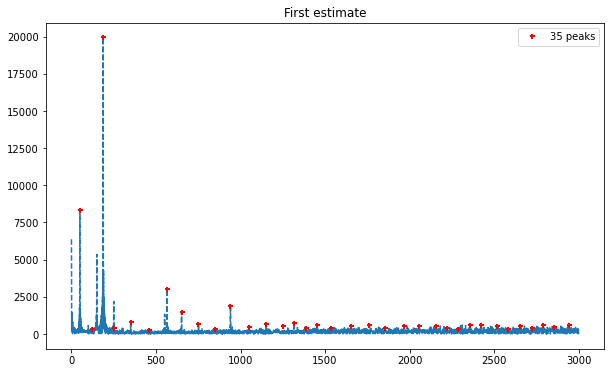

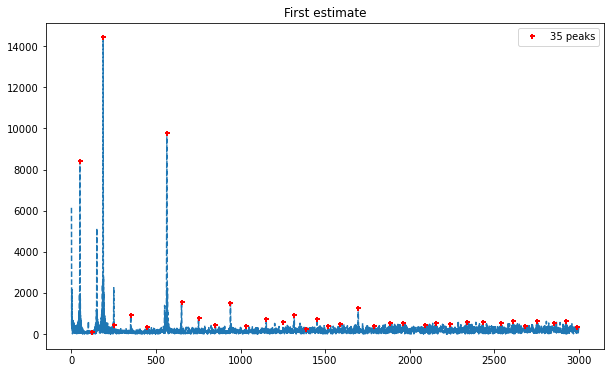

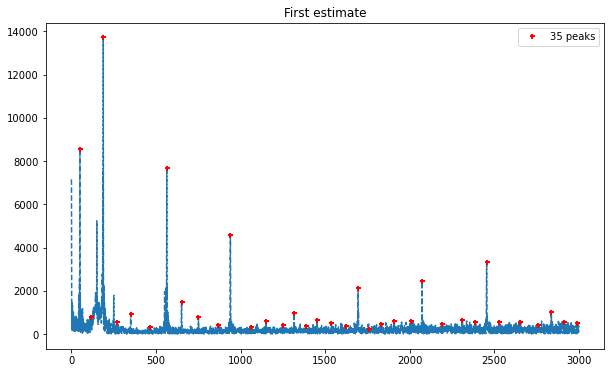

([15764539.822324246,
  28284439.72941042,
  14431402.735767212,
  8280705.031949362,
  4689328.5493768165,
  3048051.397252997,
  1732553.1195429303,
  1103047.1047033493,
  691640.072767761,
  383313.6569449153,
  296818.2710170823,
  169332.41128210328,
  106066.9746933017,
  83488.877371776,
  38753.936717285345,
  38274.42220508281,
  18462.32344221588,
  12809.043661032205,
  12555.495524008318,
  5763.012816774482,
  7119.889747615302,
  2571.14297280766,
  1759.4761763697934,
  2004.1984238604923],
 [375.25758171830097,
  375.0359666780556,
  374.94098880366613,
  374.9093295122046,
  374.84601092927664,
  374.8776702207382,
  374.8776702207382,
  374.8776702207382,
  374.8776702207382,
  374.7826923463487,
  374.9093295122046,
  374.8776702207382,
  374.8143516378102,
  374.84601092927664,
  374.0861879341461,
  374.8776702207382,
  374.9093295122046,
  375.00430738659406,
  375.00430738659406,
  382.9824488354278,
  375.0359666780556,
  379.6898825232086,
  384.4071169512896,

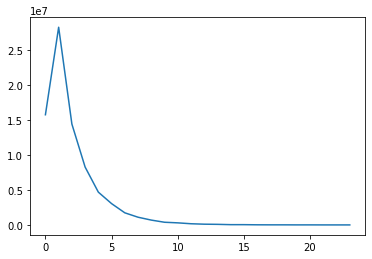

In [76]:
find_decay(input_data_decay,360,400,0.2)

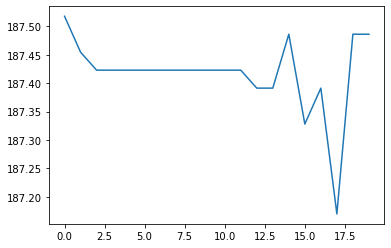

In [52]:
plt.plot(freq_list)

take f transform and power spectrum